In [2]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# #4

In [3]:
patients = np.array([49,58,75,110,112,132,151,276,281,362])

m0 = 200

statisctic, pvalue = stats.wilcoxon(patients - m0, mode = 'approx', alternative = 'two-sided')
np.round(pvalue, 4)

0.2845

# #5

In [4]:
forest = np.array([22,22,15,13,19,19,18,20,21,13,13,15])
deforest = np.array([17,18,18,15,12,4,14,15,10])

print('95%% confidence intterval for the mean forest: [%f, %f]' %(zconfint(forest)))
print('95%% confidence intterval for the mean forest: [%f, %f]' %(zconfint(deforest)))

95% confidence intterval for the mean forest: [15.503261, 19.496739]
95% confidence intterval for the mean forest: [10.726721, 16.606613]


In [53]:
_, pvalue = stats.mannwhitneyu(forest, deforest, alternative = 'greater')
np.round(pvalue, 4)

0.029

# #6

In [6]:
temps = pd.read_csv('challenger.txt', sep = '\t', header = 0)
temps.drop(columns = ['Unnamed: 0'], inplace = True)
temps.head(10)

,Temperature,Incident
0,18.9,0
1,21.1,1
2,20.6,0
3,20.0,0
4,19.4,0
5,22.2,0
6,22.8,0
7,21.1,0
8,13.9,1
9,17.2,1


In [28]:
incident0 = np.array(temps[temps["Incident"] == 0].Temperature)
incident1 = np.array(temps[temps["Incident"] == 1].Temperature)

(array([1., 1., 1., 0., 1., 0., 0., 2., 0., 1.]),
 array([11.7 , 12.92, 14.14, 15.36, 16.58, 17.8 , 19.02, 20.24, 21.46,
        22.68, 23.9 ]),
 <BarContainer object of 10 artists>)

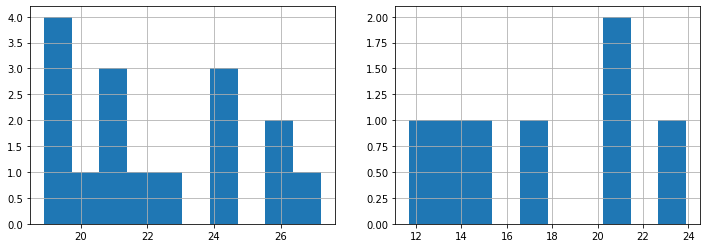

In [29]:
pylab.figure(figsize = (12, 4))

pylab.subplot(1, 2, 1)
pylab.grid()
pylab.hist(incident0)

pylab.subplot(1, 2, 2)
pylab.grid()
pylab.hist(incident1)

In [21]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [22]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [45]:
np.random.seed(0)

samples0 = get_bootstrap_samples(incident0, 1000)
samples1 = get_bootstrap_samples(incident1, 1000)

In [46]:
dif_mean = incident0.mean() - incident1.mean()
dif_mean

4.666964285714283

In [49]:
samples0_score = list(map(np.mean, samples0))
samples1_score = list(map(np.mean, samples1))

delta_temps = list(map(lambda x: x[1] - x[0], zip(samples1_score, samples0_score)))
print("95% confidence interval for the difference between temps",  stat_intervals(delta_temps, 0.05))
print(np.round(stat_intervals(delta_temps, 0.05)[0], 4))

95% confidence interval for the difference between temps [1.42299107 7.93861607]
1.423


# #7

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [17]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return[(index[:n1], index[n1:]) for index in indices]

In [20]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                   for index in itertools.combinations(range(n), n1)]
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [51]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [52]:
np.random.seed(0)

permutation_test(incident0, incident1, max_permutations = 10000)




0.007